In [16]:
#importing the requests library
import requests
import pandas as pd
import json
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

Using [marketstack](https://marketstack.com/?utm_source=Geekflare&utm_medium=LeadsAcquisition&utm_content=Listing) to make API calls to retrieve end-of-day stock price of your preferred company.

API documentations can be found [here](https://marketstack.com/documentation). Code examples for different languages can be found [here](https://marketstack.com/documentation#php)

In [2]:
def enter_ticker(symbol):
    #making the request
    url = 'http://api.marketstack.com/v1/eod'
    params = {
        'access_key' : '038908b69357069eadcfc963cbafe6ee',
        'symbols' : symbol,
        'limit' : 600
         }
    resp = requests.get(url,params=params)
    data = resp.json()
     
    df = pd.DataFrame(data=data['data'])
    df['date'] = df['date'].astype('datetime64[ns]')
    df.set_index('date',inplace=True)
    return df

In [53]:
def viz(ticker_df):
    info_df = ticker_df.loc[:,['close','volume']]
    scaler = StandardScaler()
    scaled_df = pd.DataFrame(data=scaler.fit_transform(info_df),columns=info_df.columns,index=info_df.index)
    return scaled_df.plot(figsize=(12,8))

In [38]:
amazon = enter_ticker('AMZN')
amazon

,open,high,low,close,volume,adj_high,adj_low,adj_close,adj_open,adj_volume,split_factor,dividend,symbol,exchange
date,,,,,,,,,,,,,,
2023-03-07,94.0600,95.0900,92.7800,93.5500,49100668.0,95.090,92.78,93.5500,94.06,49100668.0,1.0,0.0,AMZN,XNAS
2023-03-06,95.1900,96.5500,93.7400,93.7500,52008400.0,96.545,93.74,93.7500,95.19,52112355.0,1.0,0.0,AMZN,XNAS
2023-03-03,92.7400,94.9400,92.6600,94.9000,55695300.0,94.940,92.66,94.9000,92.74,55759609.0,1.0,0.0,AMZN,XNAS
2023-03-02,91.4100,92.2300,90.3900,92.1300,55509400.0,92.230,90.39,92.1300,91.41,55574820.0,1.0,0.0,AMZN,XNAS
2023-03-01,93.8700,94.6800,91.5900,92.1700,52145000.0,94.680,91.59,92.1700,93.87,52299524.0,1.0,0.0,AMZN,XNAS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-14,2919.6201,2948.2898,2817.6799,2837.0601,3547636.0,NaN,NaN,2837.0601,NaN,NaN,1.0,0.0,AMZN,XNAS
2022-03-11,2991.4900,2993.5000,2907.3799,2910.4900,3440500.0,NaN,NaN,2910.4900,NaN,NaN,1.0,0.0,AMZN,XNAS
2022-03-10,2913.7000,2973.4851,2880.0000,2936.3501,6753145.0,NaN,NaN,2936.3501,NaN,NaN,1.0,0.0,AMZN,XNAS


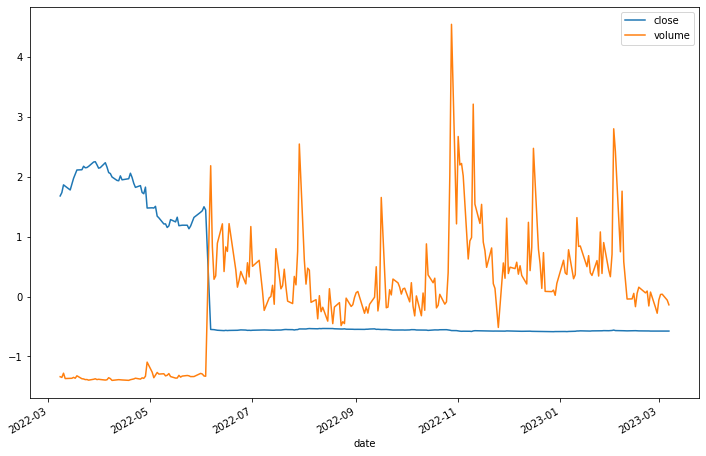

In [55]:
amazon_viz = viz(amazon)

### calculating stock returns

In [71]:
amazon_adj_close = amazon[['adj_close']]
amazon_adj_close

,adj_close
date,
2023-03-07,93.5500
2023-03-06,93.7500
2023-03-03,94.9000
2023-03-02,92.1300
2023-03-01,92.1700
...,...
2022-03-14,2837.0601
2022-03-11,2910.4900
2022-03-10,2936.3501


In [72]:
amazon_adj_close.reset_index()

,date,adj_close
0,2023-03-07,93.5500
1,2023-03-06,93.7500
2,2023-03-03,94.9000
3,2023-03-02,92.1300
4,2023-03-01,92.1700
...,...,...
246,2022-03-14,2837.0601
247,2022-03-11,2910.4900
248,2022-03-10,2936.3501
249,2022-03-09,2785.5801


In [73]:
amazon_adj_close['pct_change'] = amazon_adj_close.pct_change(1)
amazon_adj_close

<ipython-input-73-4927dadfac77>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amazon_adj_close['pct_change'] = amazon_adj_close.pct_change(1)


,adj_close,pct_change
date,,
2023-03-07,93.5500,NaN
2023-03-06,93.7500,0.002138
2023-03-03,94.9000,0.012267
2023-03-02,92.1300,-0.029189
2023-03-01,92.1700,0.000434
...,...,...
2022-03-14,2837.0601,-0.037414
2022-03-11,2910.4900,0.025882
2022-03-10,2936.3501,0.008885


<AxesSubplot:xlabel='date'>

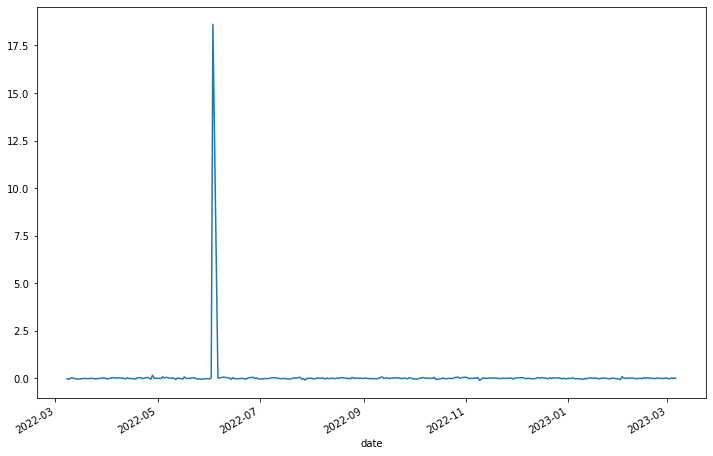

In [75]:
amazon_adj_close['pct_change'].plot(figsize=(12,8))

In [77]:
oxy = enter_ticker('OXY')

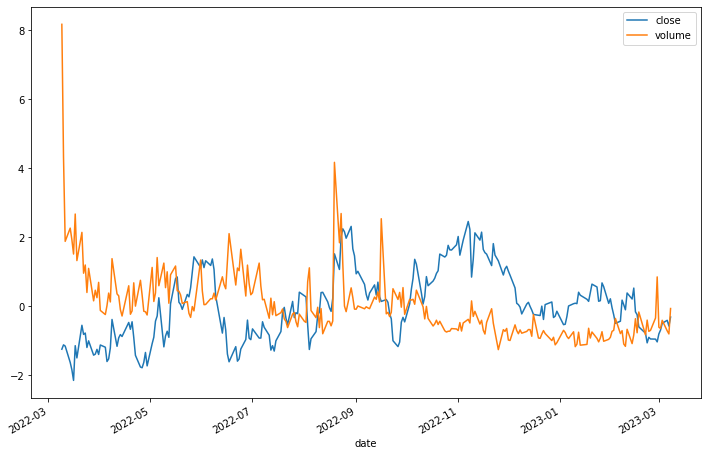

In [79]:
oxy_viz = viz(oxy)

In [81]:
oxy_close = oxy[['close']]
oxy_close

,close
date,
2023-03-08,62.15
2023-03-07,60.85
2023-03-06,61.68
2023-03-03,61.25
2023-03-02,60.27
...,...
2022-03-15,54.53
2022-03-14,55.59
2022-03-11,57.95


In [82]:
oxy_close['pct_change'] = oxy_close['close'].pct_change(1)
oxy_close

<ipython-input-82-142523d4a7ba>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oxy_close['pct_change'] = oxy_close['close'].pct_change(1)


,close,pct_change
date,,
2023-03-08,62.15,NaN
2023-03-07,60.85,-0.020917
2023-03-06,61.68,0.013640
2023-03-03,61.25,-0.006971
2023-03-02,60.27,-0.016000
...,...,...
2022-03-15,54.53,0.029062
2022-03-14,55.59,0.019439
2022-03-11,57.95,0.042454


<AxesSubplot:xlabel='date'>

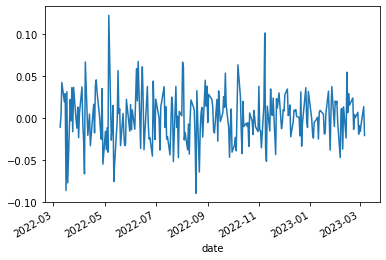

In [83]:
oxy_close['pct_change'].plot()

## stock evaluation

1. risk - need to calculate beta ratio
2. p/e ratio
3. p/b ratio
4. div yield

In [84]:
    url = 'http://api.marketstack.com/v1/eod'
    params = {
        'access_key' : '038908b69357069eadcfc963cbafe6ee',
        'symbols' : 'OXY',
        'limit' : 600
         }
    resp = requests.get(url,params=params)
    data = resp.json()

In [85]:
data

{'pagination': {'limit': 600, 'offset': 0, 'count': 251, 'total': 251},
 'data': [{'open': 62.0,
   'high': 63.575,
   'low': 61.0504,
   'close': 62.15,
   'volume': 21763054.0,
   'adj_high': 63.575,
   'adj_low': 61.05,
   'adj_close': 62.15,
   'adj_open': 62.0,
   'adj_volume': 22785931.0,
   'split_factor': 1.0,
   'dividend': 0.0,
   'symbol': 'OXY',
   'exchange': 'XNYS',
   'date': '2023-03-08T00:00:00+0000'},
  {'open': 61.315,
   'high': 61.65,
   'low': 60.51,
   'close': 60.85,
   'volume': 11668916.0,
   'adj_high': 61.65,
   'adj_low': 60.5,
   'adj_close': 60.85,
   'adj_open': 61.315,
   'adj_volume': 12547298.0,
   'split_factor': 1.0,
   'dividend': 0.0,
   'symbol': 'OXY',
   'exchange': 'XNYS',
   'date': '2023-03-07T00:00:00+0000'},
  {'open': 61.06,
   'high': 61.9689,
   'low': 60.85,
   'close': 61.68,
   'volume': 12875624.0,
   'adj_high': 61.97,
   'adj_low': 60.85,
   'adj_close': 61.68,
   'adj_open': 61.06,
   'adj_volume': 12890792.0,
   'split_factor': 